<a href="https://colab.research.google.com/github/namoshi/colab/blob/master/%E6%85%B6%E6%87%89_%E7%90%86%E5%B7%A5%E5%AD%A6%E5%9F%BA%E7%A4%8E%E5%AE%9F%E9%A8%93_%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF_%E5%AE%9F%E7%BF%923.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

慶應義塾大学　理工学部
# 理工学基礎実験　ニューラルネットワーク　実習3

情報工学科　教授　杉浦孔明

# ライブラリの準備

以下では、まず実習に必要なPythonライブラリ（特定の機能を提供するプログラムの集まり）を読み込みます。

In [1]:
from base64 import b64decode
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from google.colab.output import eval_js
from IPython.display import HTML, display
from matplotlib import cm
from PIL import Image
from torch import nn
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

# MNISTデータセットのダウンロード
MNISTデータセットをダウンロードします。

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

training_set = datasets.MNIST(
    "./data", train=True, download=True, transform=transform
)
test_set = datasets.MNIST(
    "./data", train=False, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    training_set, batch_size=64, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=10000
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11759356.69it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 350782.42it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3230327.16it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11658830.34it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# ニューラルネットの作成

In [3]:
# 空のニューラルネットを作成
my_model = nn.Sequential()

# 入力層を追加。28x28の画像を784次元のベクトルに変換。
my_model.append(nn.Flatten(1, -1))

# この下から自分でプログラムを書いてみましょう
my_model.append(nn.LazyLinear(128))
my_model.append(nn.ReLU())
my_model.append(nn.LazyLinear(10))


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): LazyLinear(in_features=0, out_features=128, bias=True)
  (2): ReLU()
  (3): LazyLinear(in_features=0, out_features=10, bias=True)
)

In [4]:
my_model.append(nn.BatchNorm1d(10))

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): LazyLinear(in_features=0, out_features=128, bias=True)
  (2): ReLU()
  (3): LazyLinear(in_features=0, out_features=10, bias=True)
  (4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

# 学習・テストの処理の詳細

モデルの訓練・テスト・描画処理

In [5]:
def train(model, device, train_loader, optimizer):
    """モデルの訓練を行う関数

    引数:
        model: 訓練するモデル
        device: モデルを訓練するデバイス（cpuまたはgpu）
        train_loader: 訓練データのDataLoader
        optimizer: 最適化アルゴリズム

    戻り値:
        accuracy (float): エポック後のモデルの精度
        total_loss (list): エポック後のモデルの損失
    """
    model.train().to(device)
    total_loss = []
    correct = 0
    total_samples = len(train_loader.dataset)

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        # 予測結果を取得する
        p_y_hat = model(x)
        # 損失を計算する
        loss = F.cross_entropy(p_y_hat, y)
        # 誤差逆伝播を行い、パラメータを更新する
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())

        y_hat = p_y_hat.argmax(dim=1, keepdim=True)
        correct += y_hat.eq(y.view_as(y_hat)).sum().item()

    accuracy = correct / total_samples

    return accuracy, total_loss


def test(model, device, test_loader):
    """テストのための関数

    引数:
        model: 訓練するモデル
        device: モデルを訓練するデバイス（cpuまたはgpu）
        test_loader: テストデータのDataLoader

    戻り値:
        accuracy (float): エポック後のモデルの精度
        total_loss (list): エポック後のモデルの損失
        predictions (list): 各サンプルの予測クラスとその予測が正しいかのブール値のペア
        predicted_labels (list): 各サンプルの予測クラスのリスト
        probabilities (list): 各サンプルのクラス予測確率のリスト
    """
    model.eval().to(device)
    total_loss = []
    correct = 0
    predictions = []
    predicted_labels = []
    probabilities = []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            # 予測結果を取得する
            p_y_hat = model(x)
            # 損失を計算する。テストの際にはパラメータ更新は行わない
            loss = F.cross_entropy(p_y_hat, y)
            total_loss.append(loss.item())

            # 最も高い予測確率を持つクラスを取得する
            y_hat = p_y_hat.argmax(dim=1, keepdim=True)
            correct += y_hat.eq(y.view_as(y_hat)).sum().item()

            predictions.extend(
                zip(y_hat.cpu().numpy(), y_hat.eq(y.view_as(y_hat)))
            )
            predicted_labels.extend(y_hat.cpu().numpy())

            softmax_layer = nn.Softmax(dim=0)
            probabilities.extend(softmax_layer(p_y_hat).cpu().numpy())

        accuracy = correct / len(test_loader.dataset)

    return accuracy, total_loss, predictions, predicted_labels, probabilities


def plot_data(train_data, test_data, y_label, title):
    """2つのデータセットを比較するための折れ線グラフを生成。

    引数:
        train_data (list): 訓練データセットのy軸の値。
        test_data (list): テストデータセットのy軸の値。
        y_label (str): y軸のラベル。
        title (str): グラフのタイトル。
    """
    y1_label = f"Training {y_label.lower()}"
    y2_label = f"Test {y_label.lower()}"
    x_values = range(0,len(train_data))
    plt.plot(x_values, train_data, label=y1_label)
    x_values = range(0,len(test_data))
    plt.plot(x_values, test_data, label=y2_label)
    plt.figure()
    plt.xlabel("Epochs")
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(range(1, len(x_values) + 1, 2))
    plt.legend()
    plt.show()

# 学習

In [6]:
# @title 学習の設定 {run: "auto"}
# @markdown 学習率
LEARNING_RATE = 0.02  # @param {type: "number"}

[Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Serial id: 1, Label: 2


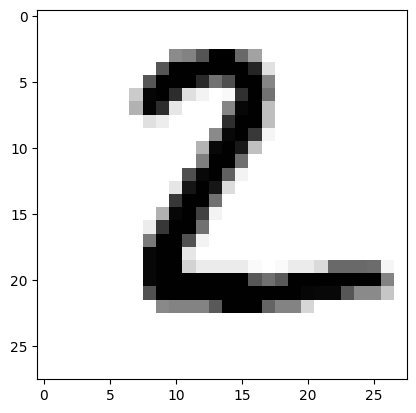

エポック 1

訓練集合   :  (精度) 0.9231666666666667, (損失) 0.4143556300034401

テスト集合 :  (精度) 0.961, (損失) 0.20022396743297577



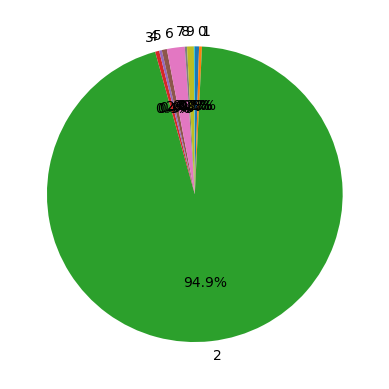

エポック 2

訓練集合   :  (精度) 0.96145, (損失) 0.1923531241206599

テスト集合 :  (精度) 0.97, (損失) 0.1334465593099594



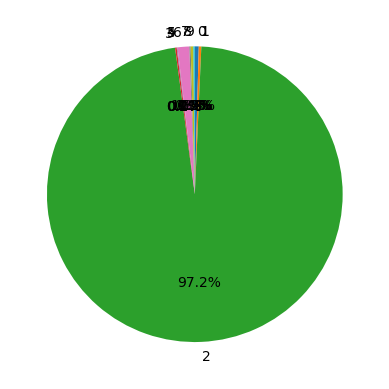

エポック 3

訓練集合   :  (精度) 0.9715333333333334, (損失) 0.13876264152734646

テスト集合 :  (精度) 0.9741, (損失) 0.11482686549425125



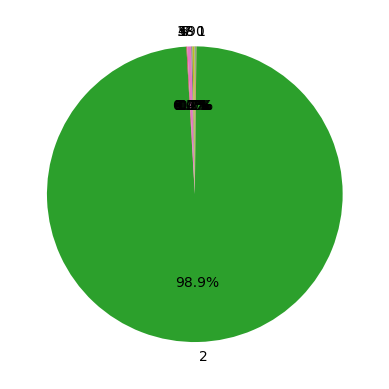

エポック 4

訓練集合   :  (精度) 0.97595, (損失) 0.11276639979690123

テスト集合 :  (精度) 0.9774, (損失) 0.09923940896987915



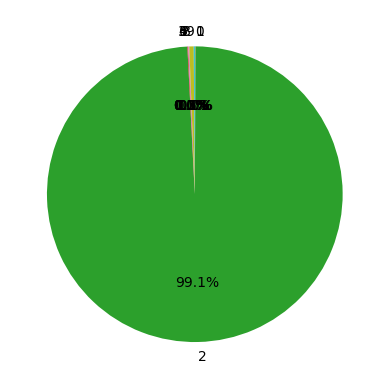

エポック 5

訓練集合   :  (精度) 0.9795833333333334, (損失) 0.09353884999979852

テスト集合 :  (精度) 0.9779, (損失) 0.09323683381080627



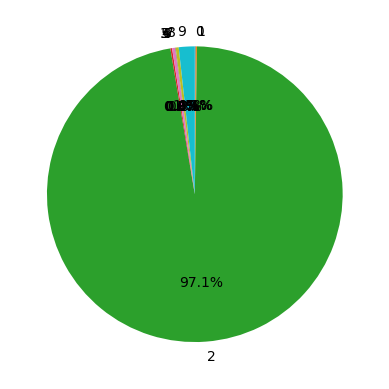

エポック 6

訓練集合   :  (精度) 0.9825333333333334, (損失) 0.08141297344634654

テスト集合 :  (精度) 0.9776, (損失) 0.0895163044333458



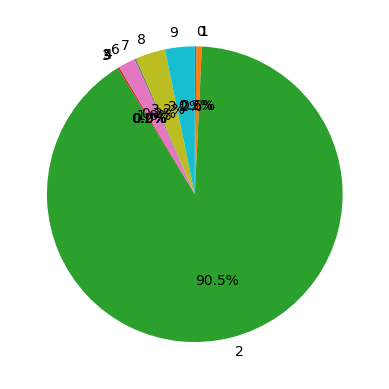

エポック 7

訓練集合   :  (精度) 0.9844666666666667, (損失) 0.07279681583751303

テスト集合 :  (精度) 0.979, (損失) 0.07853622734546661



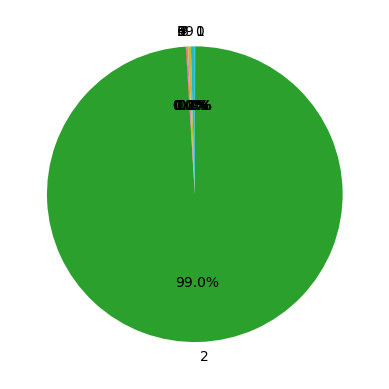

エポック 8

訓練集合   :  (精度) 0.9870333333333333, (損失) 0.06286587084490639

テスト集合 :  (精度) 0.9773, (損失) 0.08289603143930435



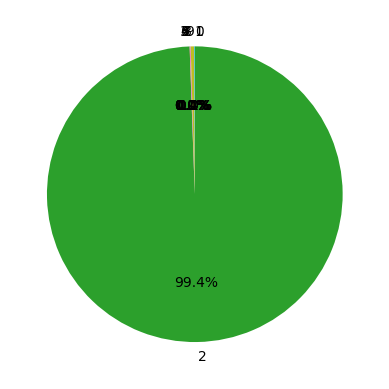

エポック 9

訓練集合   :  (精度) 0.9883833333333333, (損失) 0.05698251753036719

テスト集合 :  (精度) 0.9795, (損失) 0.07391246408224106



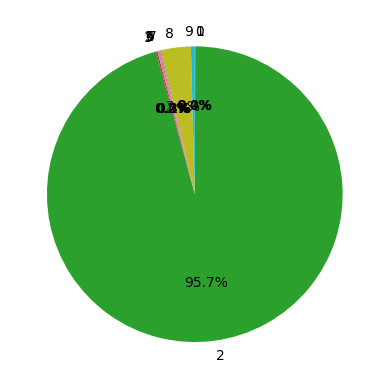

エポック 10

訓練集合   :  (精度) 0.9895, (損失) 0.051705891871129846

テスト集合 :  (精度) 0.9799, (損失) 0.07361570745706558



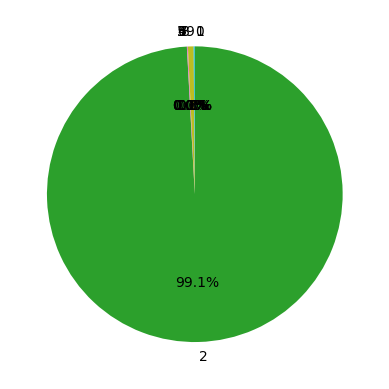

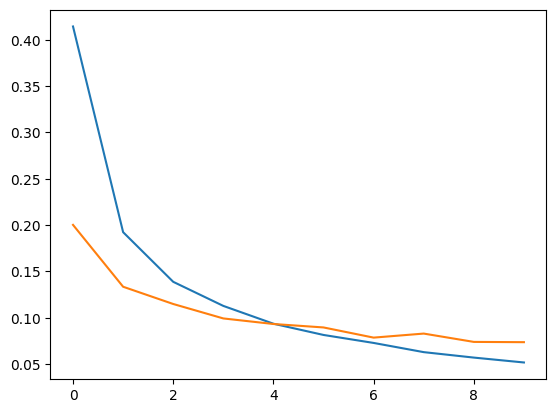

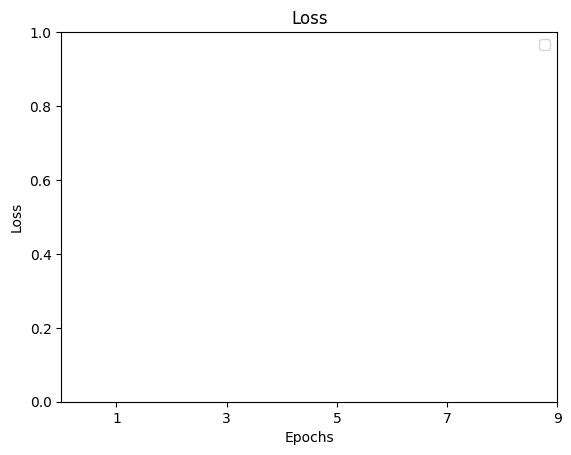

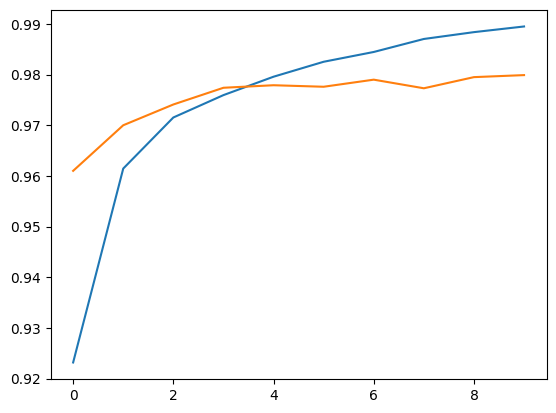

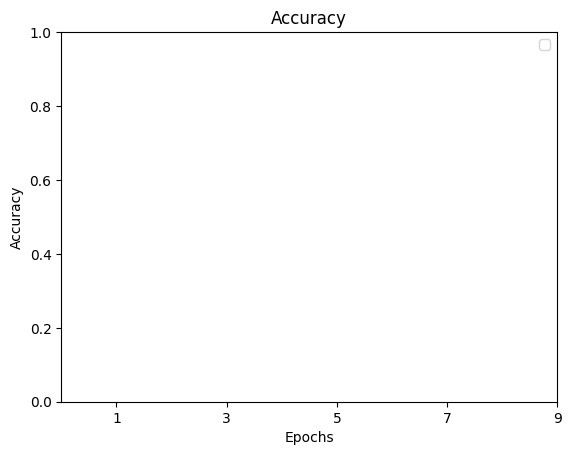

In [7]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# GPUで実行
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 最適化関数にはSGDを使用
optimizer = torch.optim.SGD(my_model.parameters(), lr=LEARNING_RATE)
# エポック数の設定
NUM_EPOCHS = 10

# 反復処理
for epoch in tqdm(range(NUM_EPOCHS), total=NUM_EPOCHS, desc="[Training]"):
    # モデルを訓練し、訓練集合に対する精度(train_acc)と損失(train_loss)を取得する
    train_acc, train_loss \
        = train(my_model, device, train_loader, optimizer)
    # テスト集合に対する精度(test_acc)及び損失(test_loss)を取得する
    (test_acc, test_loss, test_predictions,
     test_predict_labels, test_probabilities) \
        = test(my_model, device, test_loader)

    RANDOM_NUMBER = 1
    if epoch == 0:
        img, label = test_loader.dataset[RANDOM_NUMBER]
        print(f"Serial id: {RANDOM_NUMBER}, Label: {label}")
        plt.imshow(img.reshape(28, 28), cmap=cm.gray_r)
        plt.show()

    print(f"エポック {epoch + 1}\n")
    print(f"訓練集合   :  (精度) {train_acc}, (損失) {np.mean(train_loss)}\n")
    print(f"テスト集合 :  (精度) {test_acc}, (損失) {np.mean(test_loss)}\n")

    # 予測確率値の分布を円グラフで表示
    plt.pie(
        test_probabilities[RANDOM_NUMBER],
        labels=[str(i) for i in range(10)],
        counterclock=False,
        startangle=90,
        autopct="%1.1f%%",
    )
    plt.show()

    train_losses.append(np.mean(train_loss))
    test_losses.append(np.mean(test_loss))
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# 訓練集合およびテスト集合に対する損失をプロットする
plot_data(train_losses, test_losses, "Loss", "Loss")

# 訓練集合およびテスト集合に対する精度をプロットする
plot_data(train_accuracies, test_accuracies, "Accuracy", "Accuracy")

# 分類に成功した画像と失敗した画像の表示
以下のコードセルを順に実行してください

Ⅰ. テスト集合を学習済みモデルを使って評価します

In [8]:
# 0から9までのキーと、SuccessとFailureの空の配列を値として持つ辞書(results_index)を初期化する
results_index = {
    number: {
        "Success": np.array([]), "Failure": np.array([])
    } for number in range(10)
}

# 各サンプルの正解ラベルと予測結果(True/False)をペアとしたリスト(ground_truth_and_prediction)を作成する
ground_truth = [y.numpy() for (x, y) in test_loader]
ground_truth_and_prediction = []
for index, prediction in enumerate(test_predictions):
    ground_truth_and_prediction.append(
        [ground_truth[0][index], prediction[1][0].cpu().numpy()]
    )
ground_truth_and_prediction = np.array(ground_truth_and_prediction)

# 0から9までの各数字を反復処理する
for number in range(10):
    # 現在の数字の成功条件と失敗条件を定義する
    success_condition = (ground_truth_and_prediction[:, 0] == number) & (
        ground_truth_and_prediction[:, 1] == 1
    )
    failure_condition = (ground_truth_and_prediction[:, 0] == number) & (
        ground_truth_and_prediction[:, 1] == 0
    )

    # 辞書(results_index)に、成功条件と失敗条件のインデックスの情報を追加
    results_index[number]["Success"] = np.where(success_condition)[0]
    results_index[number]["Failure"] = np.where(failure_condition)[0]

# 各数字の成功した予測と失敗した予測の数をカウントして、配列(results_count)を作成する
results_count = np.array(
    [
        [
            len(results_index[number]["Success"]),
            len(results_index[number]["Failure"])
        ]
        for number in range(10)
    ],
    dtype=np.int64,
)

# 表を作成して表示する
pd.DataFrame(results_count, dtype="int64", columns=["分類成功", "分類失敗"])

,分類成功,分類失敗
0,971,9
1,1124,11
2,1012,20
3,990,20
4,961,21
5,872,20
6,938,20
7,999,29
8,959,15
9,973,36


Ⅱ. 画像データを選んで表示します   
  1. まず、表示したいラベルを選びます。例えば「２」を選ぶとデータの中から正解が「２」のデータを選びます。
  2. 次に、分類に成功したデータを見るか失敗したデータを見るかを決めます。例えばチェックをつけると、「２」のデータの中から分類に成功したデータを選びます。
  3. 最後に、選んだデータ群の中から表示する１枚を、データ番号を指定して選びます。データ番号はⅠで表示したデータ数を基に決められます。 例えば正解が「２」のデータの内、分類に成功したデータが１００枚、失敗したデータが２０枚であったとき、正解「２」で分類に成功したデータはデータ番号：０〜９９の範囲で指定でき、失敗したデータはデータ番号：0~19の範囲で指定できます。

Label: 7, Predicted: 9


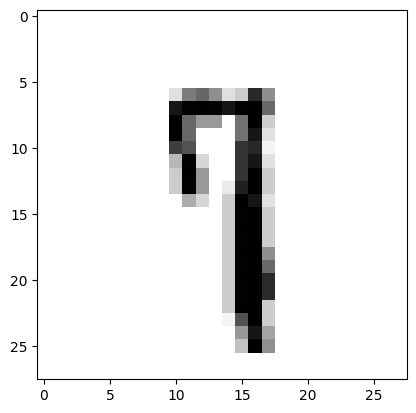

In [9]:
# @title 画像の表示
# @markdown 表示したいラベル（数字）
TARGET_LABEL = 7  # @param {type: "integer"}

# @markdown 分類に成功したか失敗したか （チェックで成功したデータを選ぶ）
PREDICT = False  # @param {type:"boolean"}

# @markdown 表示したいデータ番号　（番号は0から始まります)
DATA_NUM = 8  # @param {type: "integer"}

try:
    if PREDICT:
        idx = results_index[TARGET_LABEL]["Success"][DATA_NUM]
    else:
        idx = results_index[TARGET_LABEL]["Failure"][DATA_NUM]

    serial_number = int(idx)
    img, label = test_loader.dataset[serial_number]
    print(
        f"Label: {label}, Predicted: {test_predictions[serial_number][0][0]}"
    )
    plt.imshow(img.reshape(28, 28), cmap=cm.gray_r)
except IndexError:
    print("対応するデータがありません")

## 自身の手書き数字で試す


### I. キャンバスを用意

実行ボタンを押してください。

In [10]:
CANVAS_HTML = """
<div style="display: flex; flex-direction: column; align-items: flex-start;">
<canvas width=%d height=%d style="border:1px solid red;"></canvas>
<div style="margin-top: 10px;">
<button id="done">Done</button>
</div>
</div>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = 20;
var doneButton = document.querySelector('#done')
var mouse = {x: 0, y: 0}

ctx.fillStyle = "white";
ctx.fillRect(0, 0, canvas.width, canvas.height);

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})

canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}

canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}

var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  doneButton.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

In [11]:
def draw_image(width, height):
    """
    指定された幅と高さで画像を描画し、その画像を前処理してテンソルとして返す関数。

    引数:
        width (int): 描画する画像の幅。
        height (int): 描画する画像の高さ。

    戻り値:
        torch.Tensor: 前処理された画像のテンソル。
    """
    display(HTML(CANVAS_HTML % (width, height)))
    data_url = eval_js("data")

    binary_data = b64decode(data_url.split(",")[1])

    image = Image.open(BytesIO(binary_data)).convert("L")  # グレースケールで読み込み

    transform = transforms.Compose(
        [
            transforms.Resize((28, 28)),  # リサイズ
            transforms.ToTensor(),  # テンソルに変換
            transforms.Lambda(lambda x: 1 - x),  # ピクセル値の反転
            transforms.Normalize((0.1307,), (0.3081,)),  # 正規化
        ]
    )
    image_tensor = transform(image).to(device)

    return image_tensor

### Ⅱ. 自身で書いた数字を認識させる

書き直す場合は、もう一度再生ボタンを押してください。

In [12]:
image_tensor = draw_image(width=300, height=300)

# 推論
my_model.eval()
with torch.no_grad():
    p_y_hat = my_model(image_tensor)
    y_hat = p_y_hat.argmax(dim=1, keepdim=True)  # 最も高い予測確率を持つクラスを取得

# 予測確率値の分布を円グラフで表示
softmax_layer = nn.Softmax(dim=1)
plt.pie(
    softmax_layer(p_y_hat).cpu().numpy()[0],
    labels=[str(i) for i in range(10)],
    counterclock=False,
    startangle=90,
    autopct="%1.1f%%",
)
plt.show()

print(f"Predicted: {y_hat.item()}")

KeyboardInterrupt: 

以上で実習は終了です。